# Intro

In [1]:
# Define a vector of package names to be used in the script
package_names_vec <- c(
  "tidyverse",
  "readxl",
  "srvyr",
  "survey",
  "broom",
  "pbapply",
  "ggtext",
  "showtext",
  "viridis",
  "scales",
  "ggalluvial",
  "ggeffects",
  "emmeans",
  "repr",
  "patchwork",
  "gt",
  "png",
  "grid",
  "grDevices"
)

# Define a function to install and load required packages
package_prep <- function(names_vec) {
  # Iterate through each package name in the provided vector
  for (name in names_vec) {
    # Check if the package is already installed
    if (!require(name, character.only = TRUE)) {
      # Install the package using renv if not already installed
      install.packages(name)
      library(name,character.only = TRUE)
    }
  }
}

# Pipe the vector of package names into the package_prep function
package_names_vec |> package_prep()

options(tibble.width = Inf)




if (grepl("kaggle", getwd())) {
  paths <- list(
    input = file.path("/kaggle", "input", "cleaned-gfi","output"),
    output = file.path("/kaggle", "working", "output")
  )
} else {
  paths <- list(
    input = file.path("..", "output"),
    output = file.path("..", "figures")
  )
}

if (!dir.exists(paths$input)) {
  stop("INPUT DATA NOT FOUND\n DO NOT RUN THIS CODE.")
}

fig <- function(plot_obj,
                width,
                height,
                dpi    = 96,
                filename = "untitled",
                output_dir = "plots",
                ...) {
    output_dir = paths$output
  # 1) Ensure output directory exists
  if (!dir.exists(output_dir)) {
    dir.create(output_dir, recursive = TRUE)
  }
  
  # 2) Save to disk
  file_path <- file.path(output_dir, paste0(filename, ".png"))
  ggsave(
    filename = file_path,
    plot     = plot_obj,
    width    = width,
    height   = height,
    dpi      = dpi,
    ...
  )
  message("Saved plot to: ", normalizePath(file_path))
  
  # 3) Print & capture the plot
  print(plot_obj)
  rp <- recordPlot()
  
  # 4) Create a PNG at exactly the requested dimensions
  img_data <- repr::repr_png(
    rp,
    width  = width,
    height = height,
    res    = dpi
  )
  
  # 5) Display it inline at full size
  IRdisplay::display_png(img_data)
}


Loading required package: tidyverse

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: readxl

Loading required package: srvyr


Attaching package: ‘srvyr’


The following object is masked from ‘package:stats’:

    filter


Loading required package: survey

Loading required package: grid

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loading required package: survival


Attaching package: ‘surv

In [2]:
gfi_tbl <- paths$input |> file.path("gfi.csv") |> read_csv()
codebook_tbl <- paths$input |> file.path("codebook.csv") |> read_csv()

Rows: 1057 Columns: 22
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (22): year_b, id_i, weight_d, respondent_age_o, respondent_education_lev...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 58 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): vars, varname
dbl (1): vals

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
tidy_now <- function(model) {
  tidy(model) |>
    mutate(significance = case_when(
      p.value < 1e-4 ~ "***",
      p.value < 1e-3 ~ "**",
      p.value < 1e-2 ~ "*",
      p.value < 1e-1 ~ ".",
      TRUE ~ NA_character_
    ))
}

compare_models <- function(model_1, model_2) {
  model_1 |>
    tidy(conf.int = TRUE) |>
    select(
      term,
      estimate_orig = estimate,
      conf.low_orig = conf.low,
      conf.high_orig = conf.high,
      p.value_orig = p.value
    ) |>
    inner_join(
      model_2 |>
        tidy(conf.int = TRUE) |>
        select(
          term,
          estimate_trim = estimate,
          conf.low_trim = conf.low,
          conf.high_trim = conf.high,
          p.value_trim = p.value
        ),
      by = "term"
    ) |>
    mutate(
      diff_estimate = estimate_trim - estimate_orig,
      diff_p.value = p.value_trim - p.value_orig,
      signif_change = (p.value_orig < 0.05 & p.value_trim >= 0.05) |
        (p.value_orig >= 0.05 & p.value_trim < 0.05)
    ) |>
    filter(abs(diff_estimate) > 1e-2 | signif_change)
}


# Wrangling Data

In [4]:
excl_vars <- c(
  # irrelevant
  "id_i",

  # institutional FI
  "has_account_b",
  "has_financial_institution_account_b",
  "reason_no_account_c",
  "has_mobile_money_account_b",

  # redundancy to in_the_workforce_b
  "received_government_pension_b",
  "received_government_pension_payment_c",

  # digital FI
  "made_or_received_digital_payment_b",
  "used_phone_for_finance_b",
  # owns_mobile_phone_b,
  "any_deposit_into_account_b",
  "any_withdrawal_from_account_b",

  # withouth any meaningful impact
  "any_deposit_into_account_b",
  "any_withdrawal_from_account_b",
  "respondent_age_o",
  "owns_mobile_phone_b"
)
new_names <- c(
  "survay_year" = "year_b",
  "observation_weight" = "weight_d",
  "education_level" = "respondent_education_level_o",
  "in_workforce" = "in_the_workforce_b",
  "hh_income_quintile" = "household_income_quintile_o",
  "main_source_of_emergency_funds" = "main_source_emergency_funds_c",
  "received_government_transfer" = "received_government_transfers_c",
  "saved_in_past_year" = "saved_in_past_year_b",
  "borrowed_in_past_year" = "borrowed_in_the_past_year_c",
  "account" = "financial_and_mobile_money_i",
  "age_bracket" = "generation_i"
)





clean <- function(inp_tbl) {
  inp_tbl |>
    mutate(
      weight_d = weight_d / 2,
      financial_and_mobile_money_i = case_when(
        has_account_b == 0 ~ 0,
        has_financial_institution_account_b == 1 & has_mobile_money_account_b == 0 ~ 1,
        has_financial_institution_account_b == 1 & has_mobile_money_account_b == 1 ~ 2,
        .default = NA_integer_
      ),
      main_source_emergency_funds_c = main_source_emergency_funds_c |> case_match(
        0 ~ 0L,
        c(1, 2, 3, 5) ~ 1L,
        4 ~ 2L,
        .default = NA_integer_
      ),
      borrowed_in_the_past_year_c = borrowed_in_the_past_year_c |> case_match(
        0 ~ 0L,
        c(1, 4) ~ 1L,
        c(2, 3) ~ 2L
      ),
      received_government_transfers_c = received_government_transfers_c |> case_match(
        0 ~ 0L,
        c(2, 3) ~ 1L,
        c(1) ~ 2L
      ),
      generation_i = case_when(
        respondent_age_o <= 35 ~ 0L,
        respondent_age_o <= 50 ~ 1L,
        TRUE ~ 2L
      )
    )
}
refactor <- function(input_tbl, collapse = F,ref_account = "Doesn't have any account") {
  output_tbl <- input_tbl |> mutate(
    survay_year = survay_year |> case_match(
      2017 ~ "2017",
      2021 ~ "2021"
    ) |> factor() |> relevel(ref = "2017"),
    education_level = education_level |> case_match(
      0 ~ "Primary or Less",
      1 ~ "Secondary",
      2 ~ "Tertiary or more"
    ) |> factor() |> relevel(ref = "Primary or Less"),
    main_source_of_emergency_funds = main_source_of_emergency_funds |> case_match(
      0 ~ "Couldn't provide",
      1 ~ "Informal Channels",
      2 ~ "Financial Institutions"
    ) |> factor() |> relevel(ref = "Couldn't provide"),
    received_government_transfer = received_government_transfer |> case_match(
      0 ~ "Isn't eligable",
      1 ~ "In cash or goods",
      2 ~ "Through Account"
    ) |> factor() |> relevel(ref = "In cash or goods"),
    borrowed_in_past_year = borrowed_in_past_year |> case_match(
      0 ~ "Didn't Borrow",
      1 ~ "Through informal channels",
      2 ~ "Through Account"
    ) |> factor() |> relevel(ref = "Through informal channels"),
    account = account |> case_match(
      0 ~ "Doesn't have any account",
      1 ~ "Bank account only",
      2 ~ "Bank and Mobile money"
    ) |> factor() |> relevel(ref = ref_account),
    age_bracket = age_bracket |> case_match(
      0 ~ "Under 35",
      1 ~ "Between 35 and 50",
      2 ~ "50 and higher"
    ) |> factor() |> relevel(ref = "50 and higher")
  )

  if (!collapse) {
    output_tbl |>
      mutate(
        hh_income_quintile = hh_income_quintile |> case_match(
          0 ~ "Bottom 20%",
          1 ~ "Second 20%",
          2 ~ "Middle 20%",
          3 ~ "Fourth 20%",
          4 ~ "Richest 20%"
        ) |> factor() |> relevel(ref = "Bottom 20%")
      )
  } else {
    output_tbl
  }
}

gfi_wrangled <- gfi_tbl |>
  filter(
    respondent_age_o >= 15, # working age
    respondent_age_o <= 65, # excluding elderly
    received_government_pension_b == 0, # exluding retires, this variables has only 1 NA.
    !is.na(borrowed_in_the_past_year_c), # only three observations, I think it's safe to omit.
    !is.na(main_source_emergency_funds_c) # 11 observations, I will gamble and omit this also.
  ) |>
  clean() |>
  select(-all_of(excl_vars)) |>
  drop_na() |>
  rename(!!!new_names) |>
  refactor()


# Model

In [7]:
design <- svydesign(ids = ~1, weights = ~observation_weight, data = gfi_wrangled)
form <- in_workforce ~ survay_year + received_government_transfer + education_level +
  age_bracket + hh_income_quintile + main_source_of_emergency_funds +
  saved_in_past_year + borrowed_in_past_year + account
  
model <- svyglm(
  form,
  design = design,
  family = quasibinomial()
)

model |> tidy_now()

term,estimate,std.error,statistic,p.value,significance
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
(Intercept),-1.40747498,0.5612245,-2.5078645,1.232657e-02,.
survay_year2021,0.59314491,0.2575370,2.3031445,2.150471e-02,.
received_government_transferIsn't eligable,-0.47188242,0.2844954,-1.6586648,9.754215e-02,.
received_government_transferThrough Account,-0.26636793,0.2856840,-0.9323865,3.513943e-01,NA
education_levelSecondary,0.32702667,0.2586563,1.2643290,2.064490e-01,NA
education_levelTertiary or more,1.34820334,0.2922224,4.6136200,4.548878e-06,***
age_bracketBetween 35 and 50,0.62278736,0.3584229,1.7375770,8.263761e-02,.
age_bracketUnder 35,0.66809131,0.3498959,1.9094002,5.653767e-02,.
hh_income_quintileFourth 20%,-0.22560628,0.2910064,-0.7752623,4.383944e-01,NA


In [ ]:
print_mathjax_table <- function(model,
                                title = NULL,
                                subtitle = NULL,
                                footnote = NULL,
                                hide_cols = NULL,
                                logit = FALSE) {
  # Use broom::tidy on the model and add a significance column
  tbl <- broom::tidy(model) |>
    dplyr::mutate(significance = dplyr::case_when(
      p.value < 1e-4 ~ "***",
      p.value < 1e-3 ~ "**",
      p.value < 1e-2 ~ "*",
      p.value < 1e-1 ~ ".",
      TRUE ~ NA_character_
    ))
  # Determine which columns to hide
  default_hide <- c("std.error", "p.value", "significance")
  hide <- unique(c(default_hide, hide_cols))
  display_cols <- setdiff(names(tbl), hide)
  ncol_disp <- length(display_cols)

  # Check for special columns
  has_se <- "std.error" %in% names(tbl)
  has_pv <- "p.value" %in% names(tbl)
  has_sig_col <- "significance" %in% names(tbl)

  # Escape LaTeX‐special characters in text
  escape_special <- function(s) {
    gsub("([_%$#&{}\\\\^])", "\\\\\\1", s)
  }

  # Alignment spec: left‐aligned columns, no vertical lines
  align <- paste(rep("l", ncol_disp), collapse = "")

  # Header row: bigger font; blank for "term", “β” if estimate & logit=TRUE
  header_cells <- vapply(display_cols, function(col) {
    if (col == "term") {
      ""
    } else if (col == "estimate" && isTRUE(logit)) {
      "\\large \\beta"
    } else {
      paste0("\\text{\\large ", escape_special(col), "}")
    }
  }, character(1))
  header <- paste(header_cells, collapse = " & ")

  # Significance‐star helper (0.01→***, 0.05→**, 0.1→*)
  get_stars <- function(p) {
    if (is.na(p)) {
      return("")
    }
    if (p < 0.01) {
      return("***")
    }
    if (p < 0.05) {
      return("**")
    }
    if (p < 0.1) {
      return("\\hspace *")
    }
    ""
  }

  # Default footnote if none provided (split into two lines)
  if (is.null(footnote)) {
    footnote <- "Significance levels: *** p<0.01, ** p<0.05, * p<0.1. Note: Robust standard errors in parentheses."
  }

  # Build body rows
  body_raw <- apply(tbl, 1, function(row) {
    bold_flag <- FALSE
    if (has_sig_col) {
      sig_val <- row[["significance"]]
      if (!is.na(sig_val) && nzchar(as.character(sig_val))) {
        bold_flag <- TRUE
      }
    }

    cells <- vector("character", ncol_disp)
    for (j in seq_along(display_cols)) {
      colname <- display_cols[j]
      val <- row[[colname]]

      if (is.na(val) || identical(val, "NA")) {
        cells[j] <- ""
        next
      }

      if (colname == "estimate" && has_se) {
        # Round estimate to three decimal places
        est_raw <- suppressWarnings(as.numeric(val))
        est_fmt <- if (!is.na(est_raw)) round(est_raw, 3) else NA
        est_str <- if (!is.na(est_fmt)) as.character(est_fmt) else as.character(val)

        # Determine significance stars
        stars <- if (has_pv) get_stars(suppressWarnings(as.numeric(row[["p.value"]]))) else ""

        # Round standard error to two decimal places
        se_raw <- suppressWarnings(as.numeric(row[["std.error"]]))
        se_fmt <- if (!is.na(se_raw)) round(se_raw, 2) else NA
        se_str <- if (!is.na(se_fmt)) as.character(se_fmt) else as.character(row[["std.error"]])

        if (bold_flag) {
          line1 <- paste0("\\mathbf{", escape_special(est_str), "}", stars)
        } else {
          line1 <- paste0(escape_special(est_str), stars)
        }

        if (!is.na(se_str) && nzchar(se_str)) {
          if (bold_flag) {
            line2 <- paste0("(", "\\mathbf{", escape_special(se_str), "}", ")")
          } else {
            line2 <- paste0("(", escape_special(se_str), ")")
          }
          cells[j] <- paste0("\\begin{array}{l}", line1, " \\\\ ", line2, "\\end{array}")
        } else {
          cells[j] <- line1
        }
      } else {
        num_val <- suppressWarnings(as.numeric(val))
        if (!is.na(num_val)) {
          # Round any other numeric value to three decimal places
          num_fmt <- round(num_val, 3)
          cells[j] <- escape_special(as.character(num_fmt))
        } else {
          txt <- escape_special(as.character(val))
          cells[j] <- paste0("\\text{", txt, "}")
        }
      }
    }
    paste(cells, collapse = " & ")
  })

  # Insert empty rows between each data row (but not between estimate and std.error)
  blank_cells <- paste(rep("", ncol_disp), collapse = " & ")
  extended <- character(0)
  for (i in seq_along(body_raw)) {
    extended <- c(extended, body_raw[i])
    if (i < length(body_raw)) {
      extended <- c(extended, blank_cells)
    }
  }
  body_section <- paste(extended, collapse = " \\\\ \n")

  # Assemble the MathJax array
  table_tex <- paste0(
    "$$\n",
    "\\begin{array}{", align, "}\n",
    "\\\\ \\hline\n \\\\",
    header, "\\\\ \\\\ \\hline\n \\\\",
    body_section, " \\\\ \\\\ \\hline\n",
    "\\end{array}\n",
    "$$\n"
  )

  # Build optional title, subtitle, and footnote (footnote split into two lines)
  out <- ""
  if (!is.null(title)) {
    t <- escape_special(title)
    out <- paste0(
      out,
      "$$\n",
      "\\text{\\LARGE ", t, "}\n",
      "$$\n"
    )
  }
  if (!is.null(subtitle)) {
    s <- escape_special(subtitle)
    out <- paste0(
      out,
      "$$\n",
      "\\text{\\large ", s, "}\n",
      "$$\n"
    )
  }
  out <- paste0(out, table_tex)

  if (!is.null(footnote)) {
    parts <- strsplit(footnote, " Note: ")[[1]]
    line1 <- escape_special(parts[1])
    if (length(parts) > 1) {
      line2 <- escape_special(paste0("Note: ", parts[2]))
      foot_tex <- paste0(
        "\\text{\\small ", line1, "}", " \\\\ ",
        "\\text{\\small ", line2, "}"
      )
    } else {
      foot_tex <- paste0("\\text{\\small ", escape_special(footnote), "}")
    }
    out <- paste0(
      out,
      "$$\n",
      foot_tex, "\n",
      "$$\n"
    )
  }

  IRdisplay::display_latex(out)
}


In [77]:
model |> print_mathjax_table(logit = TRUE)

# Plots

In [101]:
# -------------------------------------------------------------------
# 1b) Polished Forest‐Style Plot with OR Labels, Borders, and Tidy Grid
# -------------------------------------------------------------------

forest_plot <- or_data |>
  ggplot(aes(x = OR, y = fct_reorder(level, OR))) +
  # Reference line at OR = 1
  geom_vline(xintercept = 1, lty = 2, color = "gray50") +
  # Points with CIs
  geom_pointrange(
    aes(xmin = CI_low, xmax = CI_high),
    shape = 16, linewidth = 0.6, color = "black"
  ) +
  # Odds‐ratio labels above each point
  geom_text(
    aes(label = sprintf("%.2f", OR)),
    color = "black",
    size = 2.5,
    vjust = -0.8
  ) +
  # Facet by predictor, two columns
  facet_wrap(~ predictor, scales = "free_y", ncol = 2) +
  # Expand x‐axis a bit so labels don't get cut off
  scale_x_log10(
    name = "Odds Ratio (log scale)",
    breaks = c(0.25, 0.5, 1, 2, 4),
    labels = scales::comma_format(accuracy = 0.1),
    expand = expansion(mult = c(0.05, 0.25))
  ) +
  labs(
    y = NULL,
    title = "Forest Plot of Odds Ratios by Predictor",
    subtitle = "Each panel shows levels of that predictor (reference = 1.00)"
  ) +
  theme_minimal(base_size = 12) +
  theme(
    # Panel border around each facet
    panel.border       = element_rect(color = "black", fill = NA, linewidth = 0.5),
    # Tidy up grid lines: major lines light gray, remove minor
    panel.grid.major.y = element_blank(),
    panel.grid.major.x = element_line(color = "gray90", linewidth = 0.3),
    panel.grid.minor   = element_blank(),
    # Strip labels formatting
    strip.background   = element_rect(fill = "#f0f0f0", color = "gray80"),
    strip.text         = element_text(face = "bold", size = 11),
    # Y‐axis text size
    axis.text.y        = element_text(size = 9),
    # Title formatting
    plot.title         = element_text(face = "bold"),
    plot.subtitle      = element_text(size = 10),
    # Remove extra spacing between facets
    strip.placement    = "outside",
    panel.spacing.y    = unit(0.5, "lines")
  )

# Print the polished forest plot
forest_plot


ERROR: Error: object 'or_data' not found


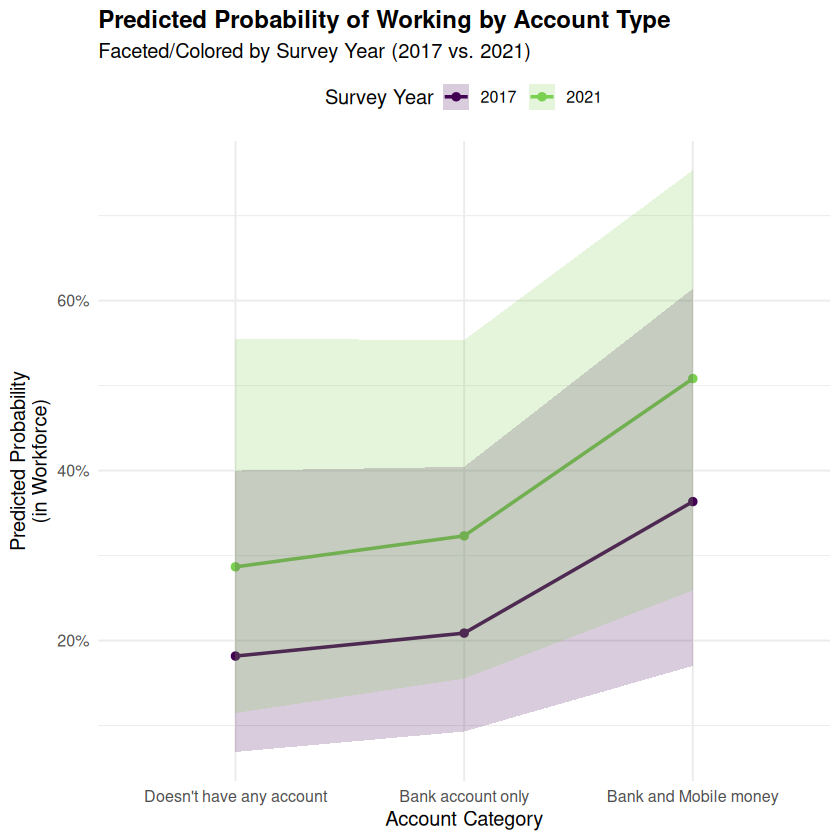

In [102]:
# 2. Predicted Probability by Account Type × Survey Year

pp_account_year <- ggeffects::ggpredict(
  model,
  terms = c("account", "survay_year"),
  type = "fixed"
) |>
  # ensure x (account levels) stays in the intended order:
  mutate(x = factor(x, levels = unique(x)))

prob_account_year_plot <- pp_account_year |>
  ggplot(aes(
    x = x,
    y = predicted,
    color = group,
    fill = group,
    group = group
  )) +
  geom_line(linewidth = 1) +
  geom_point(size = 2) +
  geom_ribbon(aes(ymin = conf.low, ymax = conf.high), alpha = 0.2, color = NA) +
  scale_y_continuous(
    name = "Predicted Probability\n(in Workforce)",
    labels = scales::percent_format(accuracy = 1)
  ) +
  scale_x_discrete(name = "Account Category") +
  scale_color_viridis_d(option = "D", end = 0.8, name = "Survey Year") +
  scale_fill_viridis_d(option = "D", end = 0.8, name = "Survey Year") +
  labs(
    title = "Predicted Probability of Working by Account Type",
    subtitle = "Faceted/Colored by Survey Year (2017 vs. 2021)"
  ) +
  theme_minimal(base_size = 12) +
  theme(
    legend.position = "top",
    plot.title = element_text(face = "bold")
  )

# Print it
prob_account_year_plot


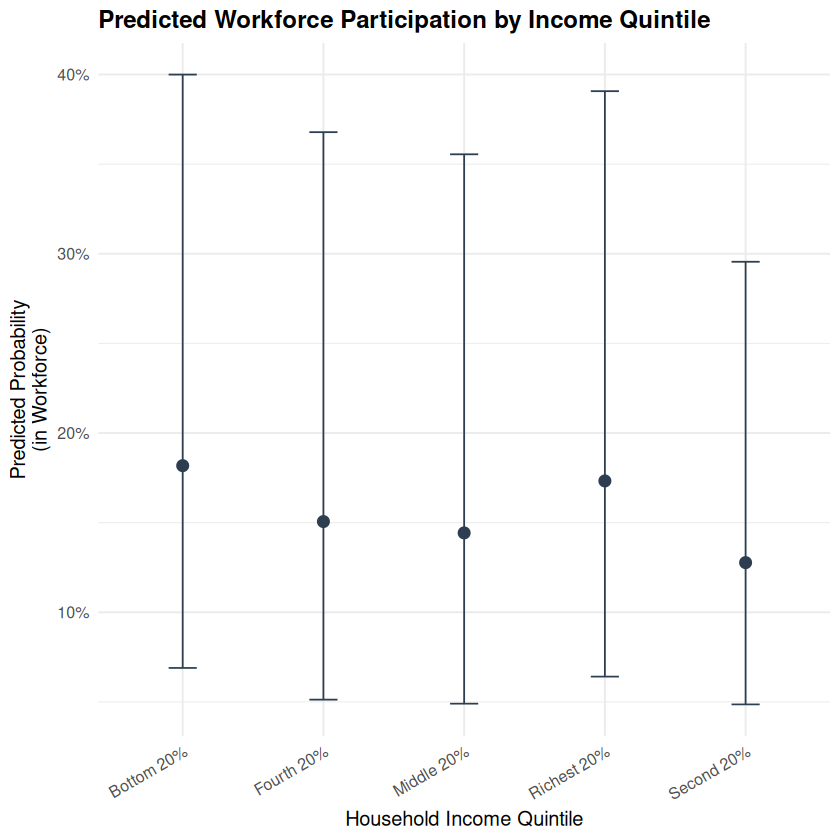

In [103]:
# 4a) Get predicted probabilities for "hh_income_quintile"
pp_income <- ggeffects::ggpredict(
  model,
  terms = "hh_income_quintile",
  type = "fixed"
)

# 4b) Simple bar‐style / point‐and‐error‐bar plot of predicted probabilities
prob_income_plot <- pp_income |>
  ggplot(aes(x = x, y = predicted)) +
  geom_point(size = 3, color = "#2c3e50") +
  geom_errorbar(aes(ymin = conf.low, ymax = conf.high), width = 0.2, color = "#2c3e50") +
  scale_y_continuous(
    name = "Predicted Probability\n(in Workforce)",
    labels = scales::percent_format(accuracy = 1)
  ) +
  scale_x_discrete(name = "Household Income Quintile") +
  labs(
    title = "Predicted Workforce Participation by Income Quintile"
  ) +
  theme_minimal(base_size = 12) +
  theme(
    axis.text.x = element_text(angle = 30, hjust = 1),
    plot.title = element_text(face = "bold")
  )

# Print it
prob_income_plot


In [104]:
# 5a) Subset to three key predictors for a cleaner “bubble” look
subset_or <- or_data |>
  filter(predictor %in% c("Survey Year", "Education", "Account Type"))

# 5b) Bubble plot: x = predictor, y = level, size = inverse CI width, color = OR
bubble_plot <- subset_or |>
  mutate(
    CI_width = CI_high - CI_low,
    size = 1 / CI_width  # narrower CI => bigger bubble
  ) |>
  ggplot(aes(
    x = predictor,
    y = fct_reorder(level, OR),
    size = size,
    color = OR
  )) +
  geom_point(alpha = 0.8) +
  scale_color_viridis_c(
    name = "Odds Ratio",
    option = "B",
    trans = "log10",
    breaks = c(0.5, 1, 2, 4),
    labels = scales::comma_format(accuracy = 0.1)
  ) +
  scale_size_continuous(
    name = "Inverse CI Width",
    range = c(2, 8)
  ) +
  labs(
    x = NULL,
    y = NULL,
    title = "Bubble Plot of Odds Ratios\n(Selected Predictors)"
  ) +
  theme_minimal(base_size = 12) +
  theme(
    axis.text.y = element_text(size = 10),
    plot.title = element_text(face = "bold"),
    legend.position = "right"
  )

# Print it
bubble_plot


ERROR: Error: object 'or_data' not found


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


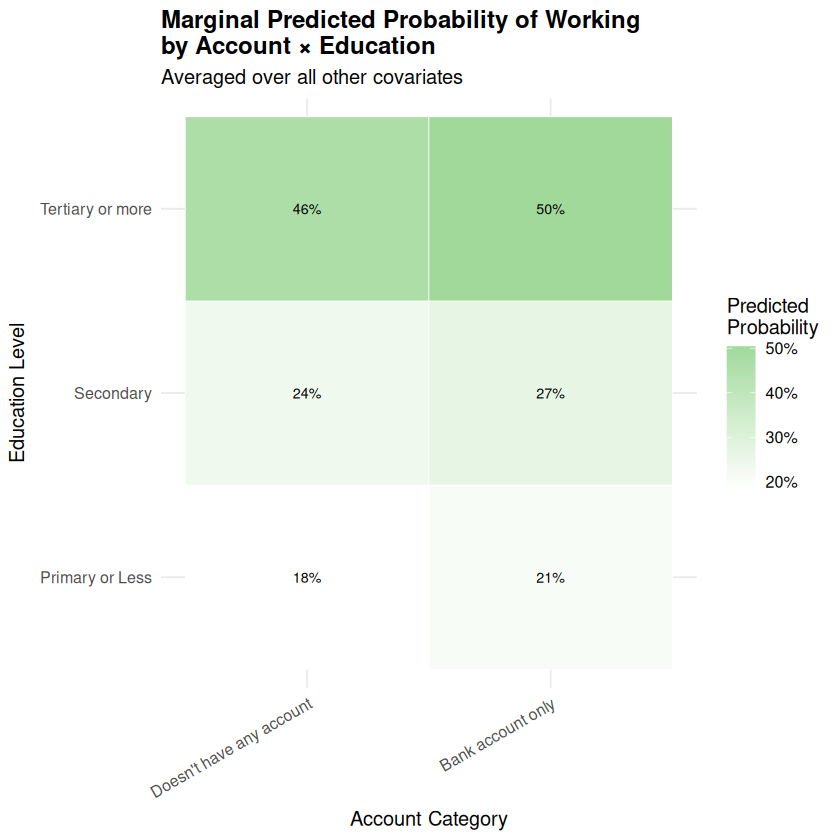

In [105]:
# -------------------------------------------------------------------
# Heatmap of Predicted Probability: Account Type × Education Level
# (White → Light Green Colorblind‐Friendly Gradient)
# -------------------------------------------------------------------

# 1) Use ggpredict() to get marginal predictions for each combination
heatmap_df <- ggeffects::ggpredict(
  model,
  terms = c("account", "education_level"),
  type  = "fixed"
) |>
  rename(
    account         = x,
    education_level = group,
    prob             = predicted,
    lower            = conf.low,
    upper            = conf.high
  ) |>
  mutate(
    account         = factor(account, levels = unique(account)),
    education_level = factor(education_level, levels = unique(education_level))
  )

# 2) Plot a tile (geom_tile) where x = Account, y = Education, fill = Predicted Prob.
heatmap_plot <- heatmap_df |>
  ggplot(aes(
    x    = account,
    y    = education_level,
    fill = prob
  )) +
  geom_tile(color = "white", size = 0.2) +
  geom_text(aes(label = scales::percent(prob, accuracy = 1)), size = 3) +
  scale_fill_gradient(
    name   = "Predicted\nProbability",
    low    = "white",
    high   = "#a1d99b",
    labels = scales::percent_format(accuracy = 1)
  ) +
  labs(
    x        = "Account Category",
    y        = "Education Level",
    title    = "Marginal Predicted Probability of Working\nby Account × Education",
    subtitle = "Averaged over all other covariates"
  ) +
  theme_minimal(base_size = 12) +
  theme(
    axis.text.x  = element_text(angle = 30, hjust = 1),
    plot.title   = element_text(face = "bold"),
    axis.title.y = element_text(vjust = 1.2)
  )

# 3) Print the heatmap
heatmap_plot


# Robustness checks

## 1. Robust to observation weights

### 1.1 Outlier cuttoff

**Explanation**: 
1. find the distribution of weights given by `observaton_weights` variable.
2. cutt the extreme 2.5% from both sides (so you've left with 95% in the middle).
3. compute the model again.
4. compare the difference between the two.

In [106]:
gfi_trimmed <- gfi_wrangled |>
  mutate(
    weight_cutoff = observation_weight |> quantile(probs = 0.95),
    trimmed_wt = pmin(observation_weight, weight_cutoff)
  )


# 3) Redefine survey design using trimmed weights
design_trim <- svydesign(
  ids = ~1,
  weights = ~trimmed_wt,
  data = gfi_trimmed
)

# 4) Re‐run the same quasibinomial model on the trimmed‐weight design
model_trim <- svyglm(
  form,
  design = design_trim,
  family = quasibinomial()
)

compare_models(model,model_trim)

term,estimate_orig,conf.low_orig,conf.high_orig,p.value_orig,estimate_trim,conf.low_trim,conf.high_trim,p.value_trim,diff_estimate,diff_p.value,signif_change
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
(Intercept),-1.40747498,-2.5089802,-0.3059698,0.01232657,-1.43507815,-2.51721360,-0.3529427,0.009402739,-0.02760317,-0.002923833,FALSE
survay_year2021,0.59314491,0.0876817,1.0986081,0.02150471,0.57430496,0.07679729,1.0718126,0.023716771,-0.01883996,0.002212058,FALSE
education_levelSecondary,0.32702667,-0.1806334,0.8346867,0.20644903,0.31450514,-0.18682592,0.8158362,0.218553357,-0.01252153,0.012104328,FALSE
hh_income_quintileRichest 20%,-0.05832182,-0.5989929,0.4823493,0.83238017,-0.04369658,-0.58000430,0.4926111,0.872986671,0.01462524,0.040606503,FALSE
hh_income_quintileSecond 20%,-0.41720457,-0.9500300,0.1156208,0.12470708,-0.37349274,-0.90092585,0.1539404,0.164931460,0.04371183,0.040224383,FALSE
main_source_of_emergency_fundsFinancial Institutions,0.34325824,-0.6241936,1.3107101,0.48638078,0.38162252,-0.58169369,1.3449387,0.437058764,0.03836428,-0.049322020,FALSE
main_source_of_emergency_fundsInformal Channels,-0.19795501,-0.7256773,0.3297673,0.46179086,-0.15936843,-0.67453114,0.3557943,0.543898127,0.03858658,0.082107267,FALSE
borrowed_in_past_yearThrough Account,0.23220672,-0.2142038,0.6786173,0.30757643,0.20035139,-0.23878675,0.6394895,0.370793362,-0.03185534,0.063216931,FALSE
accountBank account only,0.17201644,-0.5217531,0.8657859,0.62663795,0.19386572,-0.47648345,0.8642149,0.570445732,0.02184927,-0.056192216,FALSE


## 2. Robust to regression form

### 3.1 Linear Probability instead of Logit

**Explanation**: what would change if we estimated the model using a simple regression on probabilities instead of Logit, would results differ much?

In [107]:
# 2) Fit an LPM by using family = gaussian() with the same formula
model_lpm <- svyglm(
  form,
  design = design,
  family = gaussian()
)

compare_models(model, model_lpm)


term,estimate_orig,conf.low_orig,conf.high_orig,p.value_orig,estimate_trim,conf.low_trim,conf.high_trim,p.value_trim,diff_estimate,diff_p.value,signif_change
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
(Intercept),-1.40747498,-2.50898018,-0.30596979,1.232657e-02,0.210455115,0.016549281,0.40436095,3.343458e-02,1.61793010,2.110800e-02,FALSE
survay_year2021,0.59314491,0.08768170,1.09860813,2.150471e-02,0.119998945,0.023473191,0.21652470,1.488636e-02,-0.47314597,-6.618356e-03,FALSE
received_government_transferIsn't eligable,-0.47188242,-1.03025632,0.08649147,9.754215e-02,-0.093875410,-0.207642227,0.01989141,1.056963e-01,0.37800701,8.154138e-03,FALSE
received_government_transferThrough Account,-0.26636793,-0.82707485,0.29433898,3.513943e-01,-0.053502068,-0.170496301,0.06349216,3.696755e-01,0.21286587,1.828122e-02,FALSE
education_levelSecondary,0.32702667,-0.18063340,0.83468674,2.064490e-01,0.061318357,-0.032241311,0.15487802,1.986692e-01,-0.26570831,-7.779820e-03,FALSE
education_levelTertiary or more,1.34820334,0.77466362,1.92174307,4.548878e-06,0.293028492,0.179583579,0.40647340,4.866847e-07,-1.05517485,-4.062194e-06,FALSE
age_bracketBetween 35 and 50,0.62278736,-0.08068275,1.32625747,8.263761e-02,0.111122175,-0.003975828,0.22622018,5.843743e-02,-0.51166518,-2.420018e-02,FALSE
age_bracketUnder 35,0.66809131,-0.01864308,1.35482569,5.653767e-02,0.120192536,0.007524041,0.23286103,3.656982e-02,-0.54789877,-1.996785e-02,TRUE
hh_income_quintileFourth 20%,-0.22560628,-0.79675929,0.34554673,4.383944e-01,-0.043276745,-0.160125223,0.07357173,4.674749e-01,0.18232954,2.908050e-02,FALSE


### 3.2 Probit instead of Logit

**Explanation**: what would happen if we estimated the model via probit method instead of logit, would result differ much?

In [108]:
model_probit <- svyglm(
  form,
  design = design,
  family = quasibinomial(link = "probit")
)

compare_models(model,model_probit)

term,estimate_orig,conf.low_orig,conf.high_orig,p.value_orig,estimate_trim,conf.low_trim,conf.high_trim,p.value_trim,diff_estimate,diff_p.value,signif_change
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
(Intercept),-1.40747498,-2.50898018,-0.30596979,1.232657e-02,-0.84652243,-1.488584518,-0.20446034,9.822655e-03,0.56095256,-2.503918e-03,FALSE
survay_year2021,0.59314491,0.08768170,1.09860813,2.150471e-02,0.35640344,0.047781094,0.66502578,2.366168e-02,-0.23674148,2.156970e-03,FALSE
received_government_transferIsn't eligable,-0.47188242,-1.03025632,0.08649147,9.754215e-02,-0.28902015,-0.626224375,0.04818407,9.288169e-02,0.18286227,-4.660466e-03,FALSE
received_government_transferThrough Account,-0.26636793,-0.82707485,0.29433898,3.513943e-01,-0.16381483,-0.503661137,0.17603147,3.443773e-01,0.10255310,-7.016997e-03,FALSE
education_levelSecondary,0.32702667,-0.18063340,0.83468674,2.064490e-01,0.19923500,-0.102467008,0.50093700,1.952844e-01,-0.12779167,-1.116466e-02,FALSE
education_levelTertiary or more,1.34820334,0.77466362,1.92174307,4.548878e-06,0.82601557,0.482488750,1.16954239,2.754788e-06,-0.52218777,-1.794090e-06,FALSE
age_bracketBetween 35 and 50,0.62278736,-0.08068275,1.32625747,8.263761e-02,0.36856666,-0.038822921,0.77595624,7.613941e-02,-0.25422070,-6.498207e-03,FALSE
age_bracketUnder 35,0.66809131,-0.01864308,1.35482569,5.653767e-02,0.38543991,-0.009805982,0.78068579,5.594800e-02,-0.28265140,-5.896661e-04,FALSE
hh_income_quintileFourth 20%,-0.22560628,-0.79675929,0.34554673,4.383944e-01,-0.13419135,-0.477973445,0.20959075,4.438176e-01,0.09141493,5.423244e-03,FALSE


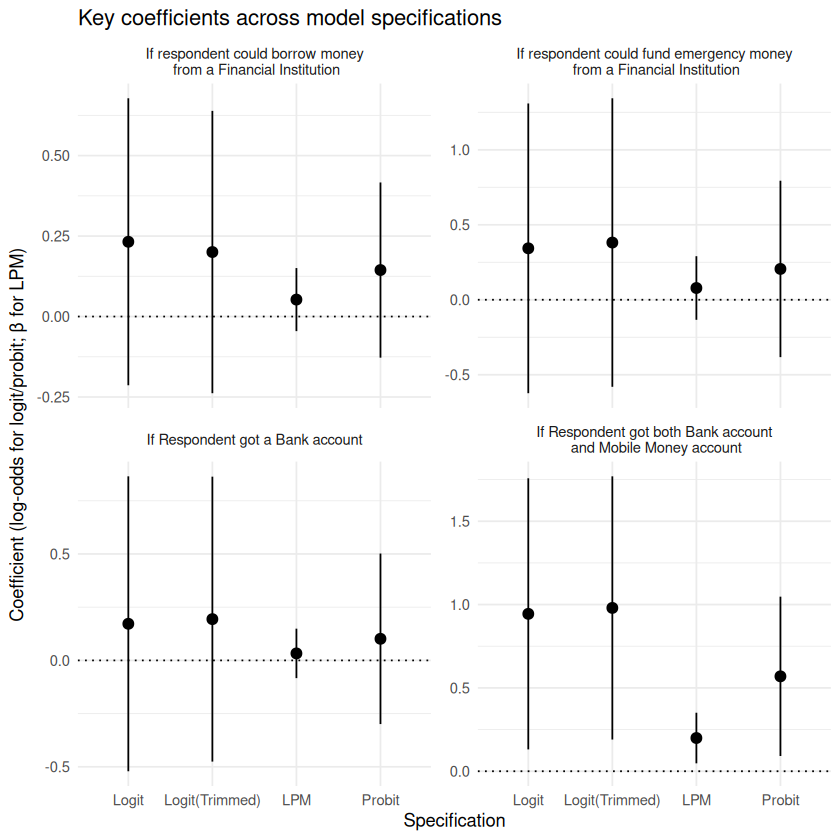

In [109]:
## Gather coefficients from all four models
coef_tbl <- list(
  Logit = model,
  `Logit(Trimmed)`  = model_trim,
  LPM            = model_lpm,
  Probit         = model_probit
) |>
  imap_dfr(~ tidy(.x) |>
    filter(term %in% c(
      "accountBank account only",
      "accountBank and Mobile money",
      "borrowed_in_past_yearThrough Account",
      "main_source_of_emergency_fundsFinancial Institutions"
    )) |>
    mutate(model = .y)) |>
  mutate(
    term = recode(term,
      "accountBank account only" = "If Respondent got a Bank account",
      "accountBank and Mobile money" = "If Respondent got both Bank account\n and Mobile Money account",
      "borrowed_in_past_yearThrough Account" = "If respondent could borrow money\n from a Financial Institution",
      "main_source_of_emergency_fundsFinancial Institutions" = "If respondent could fund emergency money\n from a Financial Institution"
    ),
    ymin = estimate - 1.96 * std.error,
    ymax = estimate + 1.96 * std.error
  )

## Plot
ggplot(
  coef_tbl,
  aes(
    x = model, y = estimate,
    ymin = ymin, ymax = ymax
  )
) +
  geom_pointrange() +
  facet_wrap(~term, scales = "free_y") +
  geom_hline(yintercept = 0, linetype = "dotted") +
  labs(
    title = "Key coefficients across model specifications",
    x = "Specification",
    y = "Coefficient (log-odds for logit/probit; β for LPM)"
  ) +
  theme_minimal(base_size = 11)


## 3. Robust to omitted variables (problematic)

### 3.1 Oster delta

*citation*
- Oster, E. (2017). Unobservable Selection and Coefficient Stability: Theory and Evidence.
Journal of Business & Economic Statistics, 37(2), 187–204. https://doi.org/10.1080/07350015.2016.1227711

In [110]:
calc_delta <- function(var_name, Y, X, design, model_lpm) {
  lpm_simple <- svyglm(
    formula = as.formula(paste0(Y, " ~ ", X)),
    design = design,
    family = gaussian()
  )
  # 1. Extract coefficient for the supplied variable from both models
  beta_R <- coef(lpm_simple)[var_name]
  beta_F <- coef(model_lpm)[var_name]

  # 2. Compute R² for restricted and full models
  R2_R <- 1 - deviance(lpm_simple) / lpm_simple$null.deviance
  R2_F <- 1 - deviance(model_lpm) / model_lpm$null.deviance

  # 3. Define the caps you want to try
  caps <- c(0.8, 0.75, 0.7)

  # 4. Build a tibble of (cap, δ)
  tibble(cap = caps) |>
    mutate(
      R_max = pmin(cap, 1.3 * R2_F),
      delta = ((beta_F - beta_R) / beta_F) *
        ((R_max - R2_F) / (R2_F - R2_R))
    ) |>
    select(cap, delta) |>
    mutate(varname = sub(paste0("^", X), paste0(X, " : "), var_name))
}

c(
  "survay_year2021",
  "received_government_transferIsn't eligable",
  "received_government_transferThrough Account",
  "education_levelSecondary",
  "education_levelTertiary or more",
  "age_bracketBetween 35 and 50",
  "age_bracketUnder 35",
  "hh_income_quintileFourth 20%",
  "hh_income_quintileMiddle 20%",
  "hh_income_quintileRichest 20%",
  "hh_income_quintileSecond 20%",
  "main_source_of_emergency_fundsFinancial Institutions",
  "main_source_of_emergency_fundsInformal Channels",
  "saved_in_past_year",
  "borrowed_in_past_yearDidn't Borrow",
  "borrowed_in_past_yearThrough Account",
  "accountBank account only",
  "accountBank and Mobile money"
) |>
  map2_df(
    c(
      "survay_year",
      "received_government_transfer",
      "received_government_transfer",
      "education_level",
      "education_level",
      "age_bracket",
      "age_bracket",
      "hh_income_quintile",
      "hh_income_quintile",
      "hh_income_quintile",
      "hh_income_quintile",
      "main_source_of_emergency_funds",
      "main_source_of_emergency_funds",
      "saved_in_past_year",
      "borrowed_in_past_year",
      "borrowed_in_past_year",
      "account",
      "account"
    ),
    ~ calc_delta(.x, "in_workforce", .y, design, model_lpm)
  ) |>
  pivot_wider(names_from = "cap", values_from = "delta")


varname,0.8,0.75,0.7
<chr>,<dbl>,<dbl>,<dbl>
survay_year : 2021,0.14948089,0.14948089,0.14948089
received_government_transfer : Isn't eligable,0.05564132,0.05564132,0.05564132
received_government_transfer : Through Account,0.17854064,0.17854064,0.17854064
education_level : Secondary,-0.16259224,-0.16259224,-0.16259224
education_level : Tertiary or more,-0.11418813,-0.11418813,-0.11418813
age_bracket : Between 35 and 50,-0.14835909,-0.14835909,-0.14835909
age_bracket : Under 35,-0.16599123,-0.16599123,-0.16599123
hh_income_quintile : Fourth 20%,0.13740341,0.13740341,0.13740341
hh_income_quintile : Middle 20%,0.13485885,0.13485885,0.13485885


### 3.2 Leave one out test (LOO)

**Explanation**:
1. it omits one of the variables and reruns the model, calculates the estimates.
2. it does this for all variables
3. I've done this procedure for the four key variables `borrowed_in_past_yearThrough Account`,`accountBank and Mobile money`,
`accountBank account only`

In [111]:
# vector of predictor names (excluding intercept)
preds <- attr(terms(form), "term.labels")

# helper: run glm after dropping one variable
drop_run <- function(drop_var, X) {
  ff <- reformulate(
    setdiff(preds, drop_var),
    response = "in_workforce"
  )
  fit <- svyglm(ff, design = design, family = quasibinomial())
  coefs <- coef(fit)[X]
  tibble(
    dropped = drop_var,
    !!X := coefs[1],
  )
}

pblapply(preds, drop_run, "borrowed_in_past_yearThrough Account") |>
  bind_rows() |>
  left_join(
    pblapply(preds, drop_run, "accountBank account only") |> bind_rows(),
    by = "dropped"
  ) |>
  left_join(
    pblapply(preds, drop_run, "accountBank and Mobile money") |> bind_rows(),
    by = "dropped"
  ) |>
  left_join(
    pblapply(preds, drop_run, "received_government_transferThrough Account") |> bind_rows(),
    by = "dropped"
  )


dropped,borrowed_in_past_yearThrough Account,accountBank account only,accountBank and Mobile money,received_government_transferThrough Account
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
survay_year,0.2132393,0.1795996,0.8398344,-0.3564340
received_government_transfer,0.2439241,0.2612033,1.0444121,NA
education_level,0.3884422,0.4008528,1.2520749,-0.2320058
age_bracket,0.2127754,0.1623759,0.9270921,-0.2505431
hh_income_quintile,0.2337843,0.2213857,0.9752937,-0.2410607
main_source_of_emergency_funds,0.2466209,0.1728097,0.9281042,-0.2520511
saved_in_past_year,0.2219714,0.1385060,0.8634137,-0.2482565
borrowed_in_past_year,NA,0.3117052,1.1174512,-0.2186970
account,0.2359192,NA,NA,-0.1909702


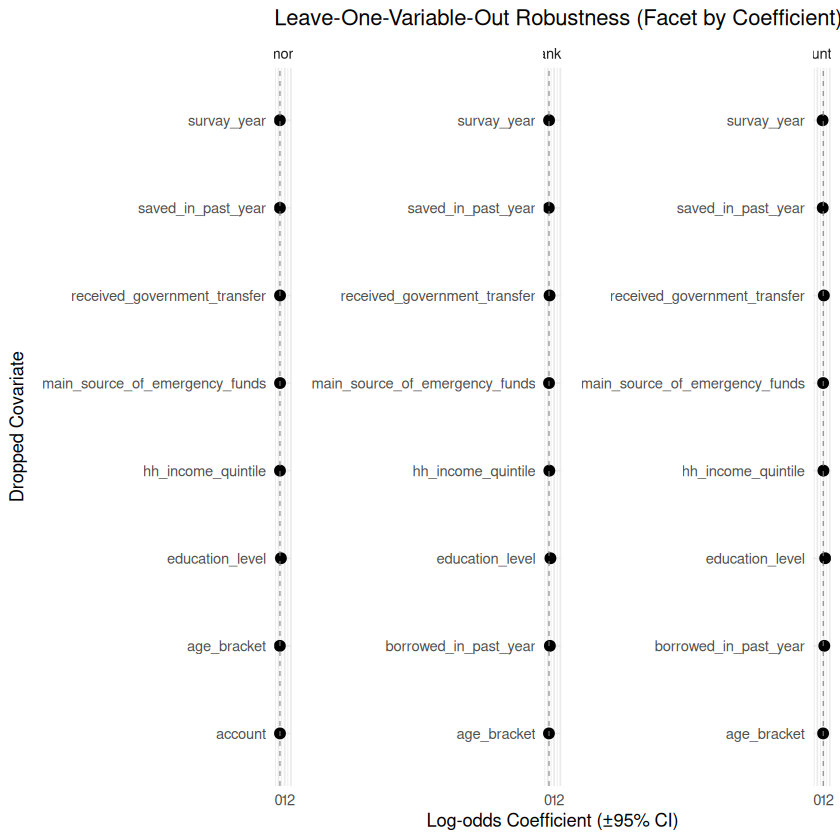

In [112]:
# 0. Define reference terms
ref_terms <- c(
  "borrowed_in_past_yearThrough Account",
  "accountBank and Mobile money",
  "accountBank account only"
)

# 1. Pull those coefficients from the full model
beta_ref <- tidy(model) |>
  filter(term %in% ref_terms) |>
  select(term, estimate) |>
  deframe()

# 2. Vector of all RHS terms in the full model
preds <- attr(terms(model), "term.labels")

# 3. Function: fit model dropping one variable, return est & SE for focal terms
drop_run <- function(drop_var) {
  form2 <- reformulate(setdiff(preds, drop_var), response = "in_workforce")
  fit <- svyglm(form2, design = design, family = quasibinomial())
  tidy(fit) |>
    filter(term %in% ref_terms) |>
    mutate(dropped = drop_var) |>
    select(dropped, term, estimate, std.error)
}

# 4. Run over all predictors
loo_tbl <- pblapply(preds, drop_run) |>
  bind_rows()

# 5. Prep for plotting: recode labels, compute 95% CIs
label_map <- c(
  "borrowed_in_past_yearThrough Account" = "If borrowed money from a FI",
  "accountBank account only"               = "If had bank account",
  "accountBank and Mobile money"           = "If had bank account + mobile money"
)

loo_plot_data <- loo_tbl |>
  mutate(
    term = recode(term, !!!label_map),
    ymin = estimate - 1.96 * std.error,
    ymax = estimate + 1.96 * std.error
  )

# 6. Put beta_ref into a tibble with the same labels
beta_ref_df <- tibble(
  term     = names(beta_ref),
  baseline = as.numeric(beta_ref)
) |>
  mutate(term = recode(term, !!!label_map))

# 7. Faceted plot
ggplot(
  loo_plot_data,
  aes(x = dropped, y = estimate, ymin = ymin, ymax = ymax)
) +
  geom_pointrange() +
  geom_hline(
    data      = beta_ref_df,
    aes(yintercept = baseline),
    linetype  = "dashed",
    colour    = "grey50",
    linewidth = 0.3
  ) +
  facet_wrap(~ term, scales = "free_y") +
  coord_flip() +
  labs(
    title = "Leave-One-Variable-Out Robustness (Facet by Coefficient)",
    x     = "Dropped Covariate",
    y     = "Log-odds Coefficient (±95% CI)"
  ) +
  theme_minimal(base_size = 11) +
  theme(legend.position = "none")


## 4. Robust to parametric form

### 4.1 Bootstrap

In [113]:
# 2. Convert to a 1000-replicate bootstrap design
set.seed(123) # for reproducibility
design_rep <- as.svrepdesign(
  design,
  type       = "bootstrap",
  replicates = 1e3
)

model_rep <- svyglm(
  form,
  design = design_rep,
  family = quasibinomial()
)

model_rep |>
compare_models(model)

term,estimate_orig,conf.low_orig,conf.high_orig,p.value_orig,estimate_trim,conf.low_trim,conf.high_trim,p.value_trim,diff_estimate,diff_p.value,signif_change
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>


## 5. Heterogeneity check

### 5.1 Only transfer-eligable women

In [139]:
gfi_trnsf <- gfi_tbl |>
  filter(
    respondent_age_o >= 15, # working age
    respondent_age_o <= 65, # excluding elderly
    received_government_pension_b == 0, # exluding retires, this variables has only 1 NA.
    !is.na(borrowed_in_the_past_year_c), # only three observations, I think it's safe to omit.
    !is.na(main_source_emergency_funds_c), # 11 observations, I will gamble and omit this also.
    received_government_transfers_c != 0
  ) |>
  clean() |>
  select(-all_of(excl_vars)) |>
  drop_na() |>
  rename(!!!new_names) |>
  refactor(collapse=TRUE)



design_trnsf <- svydesign(ids = ~1, weights = ~observation_weight, data = gfi_trnsf)
model_trnsf <- svyglm(
  form,
  design = design_trnsf,
  family = quasibinomial()
)

model_trnsf |> tidy_now()


term,estimate,std.error,statistic,p.value,significance
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
(Intercept),-1.45451903,0.92737400,-1.5684276,0.1175034865,NA
survay_year2021,0.26010969,0.36162564,0.7192789,0.4723526805,NA
received_government_transferThrough Account,-0.34823620,0.29179267,-1.1934371,0.2333442538,NA
education_levelSecondary,0.13490818,0.33431110,0.4035408,0.6867473308,NA
education_levelTertiary or more,1.38580978,0.41131915,3.3691837,0.0008206051,**
age_bracketBetween 35 and 50,0.37794042,0.44671704,0.8460399,0.3979924760,NA
age_bracketUnder 35,0.42834674,0.43863411,0.9765468,0.3293326083,NA
hh_income_quintile,0.07721954,0.09152407,0.8437075,0.3992934214,NA
main_source_of_emergency_fundsFinancial Institutions,0.27700056,0.76656306,0.3613539,0.7180091403,NA


### 5.2 Only Borrowers

In [141]:
gfi_brw <- gfi_tbl |>
  filter(
    respondent_age_o >= 15, # working age
    respondent_age_o <= 65, # excluding elderly
    received_government_pension_b == 0, # exluding retires, this variables has only 1 NA.
    !is.na(borrowed_in_the_past_year_c), # only three observations, I think it's safe to omit.
    !is.na(main_source_emergency_funds_c), # 11 observations, I will gamble and omit this also.
    borrowed_in_the_past_year_c != 0
  ) |>
  clean() |>
  select(-all_of(excl_vars)) |>
  drop_na() |>
  rename(!!!new_names) |>
  refactor()

design_brw <- svydesign(ids = ~1, weights = ~observation_weight, data = gfi_brw)
model_brw <- svyglm(
  form,
  design = design_brw,
  family = quasibinomial()
)

model_brw |> tidy_now()


term,estimate,std.error,statistic,p.value,significance
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
(Intercept),-1.53998358,0.7322901,-2.1029693,0.035895012,.
survay_year2021,0.58239895,0.2906631,2.0036904,0.045563880,.
received_government_transferIsn't eligable,-0.03392951,0.3380393,-0.1003715,0.920083800,NA
received_government_transferThrough Account,-0.16730211,0.3378459,-0.4952025,0.620643154,NA
education_levelSecondary,0.36990245,0.3090862,1.1967615,0.231884294,NA
education_levelTertiary or more,1.10868459,0.3582828,3.0944400,0.002066025,*
age_bracketBetween 35 and 50,0.29384278,0.4442875,0.6613797,0.508629224,NA
age_bracketUnder 35,0.53658657,0.4420787,1.2137807,0.225321285,NA
hh_income_quintileFourth 20%,-0.23877306,0.3471882,-0.6877338,0.491893014,NA


### 5.3 Only Non-savers

In [143]:
gfi_save <- gfi_tbl |>
  filter(
    respondent_age_o >= 15, # working age
    respondent_age_o <= 65, # excluding elderly
    received_government_pension_b == 0, # exluding retires, this variables has only 1 NA.
    !is.na(borrowed_in_the_past_year_c), # only three observations, I think it's safe to omit.
    !is.na(main_source_emergency_funds_c), # 11 observations, I will gamble and omit this also.
    saved_in_past_year_b != 0
  ) |>
  clean() |>
  select(-all_of(excl_vars)) |>
  drop_na() |>
  rename(!!!new_names) |>
  refactor()

design_save <- svydesign(ids = ~1, weights = ~observation_weight, data = gfi_save)
form_save <- in_workforce ~ survay_year + received_government_transfer + education_level +
  age_bracket + hh_income_quintile + main_source_of_emergency_funds +
  borrowed_in_past_year + account

model_save <- svyglm(
  form_save,
  design = design_save,
  family = quasibinomial()
)

model_save |> tidy_now()


term,estimate,std.error,statistic,p.value,significance
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
(Intercept),-3.3044112,1.2377960,-2.6695928,0.007902901,*
survay_year2021,-0.1255366,0.3507032,-0.3579567,0.720564039,NA
received_government_transferIsn't eligable,-0.3603958,0.4021352,-0.8962054,0.370680743,NA
received_government_transferThrough Account,0.2758081,0.4017232,0.6865625,0.492755261,NA
education_levelSecondary,-0.1981180,0.5139286,-0.3854972,0.700073501,NA
education_levelTertiary or more,1.2212006,0.5255212,2.3237895,0.020635875,.
age_bracketBetween 35 and 50,1.8170714,0.6726358,2.7014195,0.007197291,*
age_bracketUnder 35,1.1747017,0.6500780,1.8070167,0.071509060,.
hh_income_quintileFourth 20%,-0.6340884,0.4926139,-1.2871914,0.198770059,NA


## 6. Placebo

### 6.1 Only Pension receivers

In [147]:
gfi_pens <- gfi_tbl |>
  filter(
    respondent_age_o >= 15, # working age
    respondent_age_o <= 65, # excluding elderly
    received_government_pension_b == 1, # exluding retires, this variables has only 1 NA.
    !is.na(borrowed_in_the_past_year_c), # only three observations, I think it's safe to omit.
    !is.na(main_source_emergency_funds_c) # 11 observations, I will gamble and omit this also.
  ) |>
  clean() |>
  select(-all_of(excl_vars)) |>
  drop_na() |>
  rename(!!!new_names) |>
  refactor(ref="Bank account only")


design_pens <- svydesign(ids = ~1, weights = ~observation_weight, data = gfi_pens)
model_pens <- svyglm(
  form,
  design = design_pens,
  family = quasibinomial()
)

model_pens |> tidy_now()


term,estimate,std.error,statistic,p.value,significance
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
(Intercept),0.9126101,1.8788487,0.48572835,0.629281634,NA
survay_year2021,0.2020418,1.1779634,0.17151786,0.864508876,NA
received_government_transferIsn't eligable,1.0547316,1.2569274,0.83913489,0.405387816,NA
received_government_transferThrough Account,-0.1222043,1.4604525,-0.08367566,0.933648430,NA
education_levelSecondary,-2.4520920,1.3264377,-1.84862958,0.070428818,.
education_levelTertiary or more,-0.6155214,1.4740198,-0.41758011,0.678041912,NA
age_bracketBetween 35 and 50,2.0203082,0.7904181,2.55599935,0.013674165,.
age_bracketUnder 35,1.9063770,1.3537086,1.40826243,0.165241228,NA
hh_income_quintileFourth 20%,-0.5863359,1.4708559,-0.39863586,0.691858871,NA


## 7. Specification check

In [160]:
gfi_sp <- gfi_tbl |>
  filter(
    respondent_age_o >= 15, # working age
    respondent_age_o <= 65, # excluding elderly
    received_government_pension_b == 0, # exluding retires, this variables has only 1 NA.
    !is.na(borrowed_in_the_past_year_c), # only three observations, I think it's safe to omit.
    !is.na(main_source_emergency_funds_c) # 11 observations, I will gamble and omit this also.
  ) |>
clean() |>
  select(-c(
    # irrelevant
    id_i,

    # institutional FI
    has_account_b,
    has_financial_institution_account_b,
    reason_no_account_c,
    has_mobile_money_account_b,

    # redundancy to in_the_workforce_b
    received_government_pension_b,
    received_government_pension_payment_c,

    # digital FI
    #made_or_received_digital_payment_b,
    used_phone_for_finance_b,
    # owns_mobile_phone_b,
    any_deposit_into_account_b,
    any_withdrawal_from_account_b,

    # withouth any meaningful impact
    any_deposit_into_account_b,
    any_withdrawal_from_account_b,
    respondent_age_o
  )) |>
  drop_na() |>
  rename(!!!new_names) |>
  refactor()

### 7.1 specific to digital payments

In [165]:
design_dig <- svydesign(ids = ~1, weights = ~observation_weight, data = gfi_sp)
form_dig <- in_workforce ~ survay_year + received_government_transfer + education_level +
  age_bracket + hh_income_quintile + main_source_of_emergency_funds +
  saved_in_past_year + borrowed_in_past_year  + account + made_or_received_digital_payment_b

model_dig <- svyglm(
  form_dig,
  design = design_dig,
  family = quasibinomial()
)

model_dig |> tidy_now()

term,estimate,std.error,statistic,p.value,significance
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
(Intercept),-1.38451359,0.5739461,-2.4122712,1.607316e-02,.
survay_year2021,0.60868007,0.2552695,2.3844609,1.733171e-02,.
received_government_transferIsn't eligable,-0.50104630,0.3027859,-1.6547874,9.835218e-02,.
received_government_transferThrough Account,-0.22509774,0.3007532,-0.7484466,4.544065e-01,NA
education_levelSecondary,0.41742660,0.2645034,1.5781523,1.149182e-01,NA
education_levelTertiary or more,1.49071056,0.2943088,5.0651235,5.049053e-07,***
age_bracketBetween 35 and 50,0.59991302,0.3772632,1.5901709,1.121836e-01,NA
age_bracketUnder 35,0.58555782,0.3664183,1.5980581,1.104172e-01,NA
hh_income_quintileFourth 20%,-0.17608884,0.3102111,-0.5676420,5.704342e-01,NA


### 7.2 specific to owning a mobile phone

In [162]:
design_phone <- svydesign(ids = ~1, weights = ~observation_weight, data = gfi_sp)
form_phone <- in_workforce ~ survay_year + received_government_transfer + education_level +
  age_bracket + hh_income_quintile + main_source_of_emergency_funds +
  saved_in_past_year + borrowed_in_past_year + owns_mobile_phone_b + account

model_phone <- svyglm(
  form_phone,
  design = design_phone,
  family = quasibinomial()
)

model_phone |> tidy_now()

term,estimate,std.error,statistic,p.value,significance
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
(Intercept),-1.53312009,0.6074256,-2.52396368,1.179294e-02,.
survay_year2021,0.59260798,0.2529746,2.34255893,1.939175e-02,.
received_government_transferIsn't eligable,-0.53493711,0.3047327,-1.75543081,7.956131e-02,.
received_government_transferThrough Account,-0.24589714,0.3036733,-0.80974237,4.183246e-01,NA
education_levelSecondary,0.36154813,0.2673633,1.35227261,1.766632e-01,NA
education_levelTertiary or more,1.41041855,0.2990430,4.71644001,2.823056e-06,***
age_bracketBetween 35 and 50,0.60120577,0.3799017,1.58252992,1.139166e-01,NA
age_bracketUnder 35,0.59534164,0.3685486,1.61536791,1.066181e-01,NA
hh_income_quintileFourth 20%,-0.19626645,0.3074518,-0.63836504,5.234154e-01,NA
